## Geolocation by Exclusion

This model looks at the ability to perform geolocation by exclusion given RTT measurements. It looks at Atlas and MONROE separately.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

import json
import requests

from collections import namedtuple

from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore") 

Load dataframes. Run the [linear modeling](linear_modeling.ipynb) notebook first to ensure the tables have been created.

In [2]:
with pd.HDFStore('atlas_20171002.hdf5') as store:
    anchor_df = store['anchor_df']
    probe_df = store['probe_df']
    atlas_min_df = store['min_df']
    
with pd.HDFStore('monroe.hdf5') as store:
    monroe_min_df = store['min_df']

In [3]:
atlas_min_df = atlas_min_df[atlas_min_df['km'] > 0.5]

### Geolocate anchors by IP address

Go run [the RIPEstat notebook](ripestat_dataprep.ipynb) to augment `anchor_df` with the mmlon and mmlat columns, if they're not there, then start this notebook over. Now join the maxmind coordinates of the anchors back to the min dataframe.

In [4]:
atlas_min_df = atlas_min_df.join(anchor_df.loc[:,['mm4lon','mm4lat']])

### Illustration of exclusion circles

In [5]:
def pointAtBearing(lon1, lat1, b, r):
    lon1 = lon1 * math.pi / 180.0
    lat1 = lat1 * math.pi / 180.0 # convert to radians

    b = (b / 90) * math.pi / 2


    lat2 = math.asin(math.sin(lat1) * math.cos(r) + math.cos(lat1) * math.sin(r) * math.cos(b))
    lon2 = lon1 + math.atan2(math.sin(b) * math.sin(r) * math.cos(lat1), 
                             math.cos(r) - math.sin(lat1) * math.sin(lat2))
    
    lon2 = 180.0 * lon2 / math.pi
    lat2 = 180.0 * lat2 / math.pi

    return lon2, lat2

def circleWithRadius(lon, lat, km):
    """
    Return lat/lon coordinate vectors of a circle 
    with a given radius r (in units of Earth radius)
    """
    latArray = []
    lonArray = []
    
    for bearing in range(0,360):
        lon2, lat2 = pointAtBearing(lon, lat, bearing, km / 6371)
        latArray.append(lat2)
        lonArray.append(lon2)
        
    return lonArray, latArray

def plot_exclusion_circles_for(aid, amin_df, pids=None, mapscale=None, whichkm='fiber_km', figsize=(10,10)):
    # Now draw the basemap, scaled to fit most of the circles we'll draw
    alon = amin_df.iloc[0]['alon']
    alat = amin_df.iloc[0]['alat']
    plt.figure(figsize=figsize)
    try:
        m = Basemap(width=mapscale,height=mapscale,
                    resolution='i',projection='laea',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    except ValueError:
        m = Basemap(resolution='c',projection='robin',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='#dddddd')
    m.drawmapboundary(fill_color='#dddddd')
    
    # Now plot circles
    for index, row in amin_df.iterrows():
        x, y = m(row['plon'],row['plat'])
        km = row[whichkm]
        if km > ( 6371 * math.pi ):
            continue
        clon, clat = circleWithRadius(row['plon'], row['plat'], km)
        X, Y = m(clon, clat)
        plt.plot(X, Y, 'b-', alpha=0.33)
    

    # And plot a dot for the anchor
    x, y = m(alon, alat)
    plt.plot(x, y, "ro")

    # And a cross for the Maxmind geolocation of the anchor
    mm4lon = amin_df.iloc[0]['mm4lon']
    mm4lat = amin_df.iloc[0]['mm4lat']
    x, y = m(mm4lon, mm4lat)
    plt.plot(x, y, "g+")
    
    
    # print title
    print("Exclusion circles for {} probes around {}".format(len(amin_df), anchor_df.loc[aid]['name']))
 

def plot_exclusion_circles_by_range(aid, min_df, km_range=(5,250), max_rtt=50, max_probes=None, mapscale=None, whichkm = 'fiber_km', figsize=(10,10)):
    # First, get a dataframe containing only the datapoints for the anchor
    amin_df = min_df.loc[aid]
    
    # Drop probes that are outside the distance range
    amin_df = amin_df[amin_df['km'] < max(km_range)]
    amin_df = amin_df[amin_df['km'] > min(km_range)]
    
    # If distance range leads to too few probes, drop it
    if len(amin_df) < 3:
        amin_df = min_df.loc[aid]
    
    # Drop probes over max RTT
    if max_rtt is not None:
        amin_df = amin_df[amin_df['minrtt'] < max_rtt]
        # If max RTT leads to too few probes, drop it
        if len(amin_df) < 3:
            amin_df = min_df.loc[aid]

    if max_probes is not None and len(amin_df) > max_probes:
        amin_df = amin_df.sample(max_probes)
        
    if mapscale is None:
        mapscale = amin_df[whichkm].max() * 2000 + (max(km_range) * 500)

    plot_exclusion_circles_for(aid, amin_df=amin_df, mapscale=mapscale, whichkm=whichkm, figsize=figsize)

In [6]:
aid_list = atlas_min_df.index.levels[0]

Exclusion circles for 22 probes around it-trn-as12779


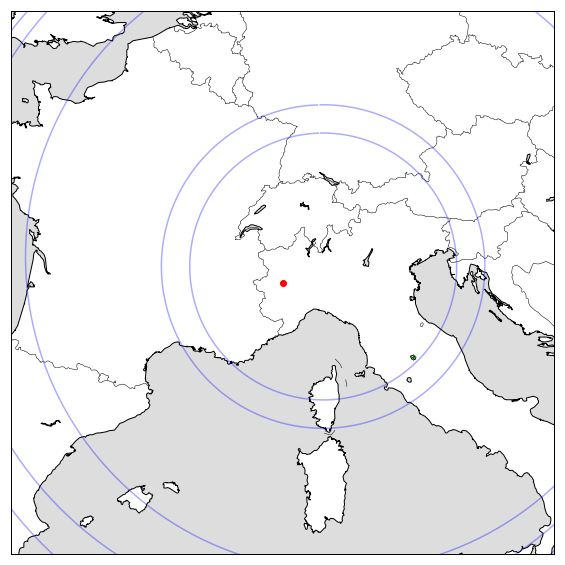

In [7]:
plot_exclusion_circles_by_range(aid_list[0],atlas_min_df,mapscale=1500000)

Exclusion circles for 80 probes around nl-ams-as3333


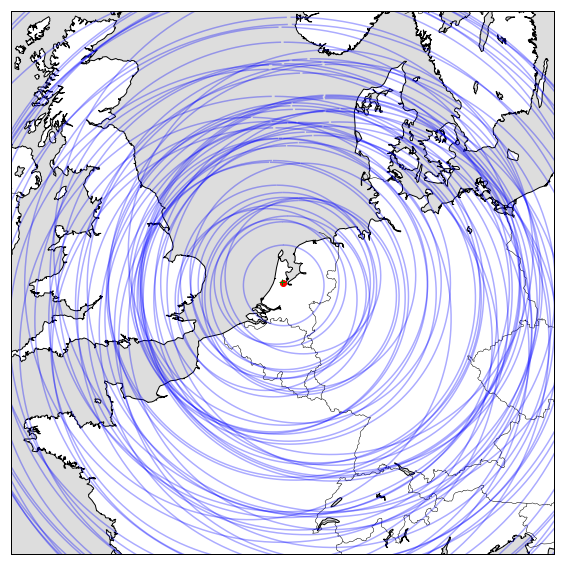

In [8]:
plot_exclusion_circles_by_range(aid_list[1],atlas_min_df, mapscale=1500000)

Exclusion circles for 76 probes around ch-zrh-as559


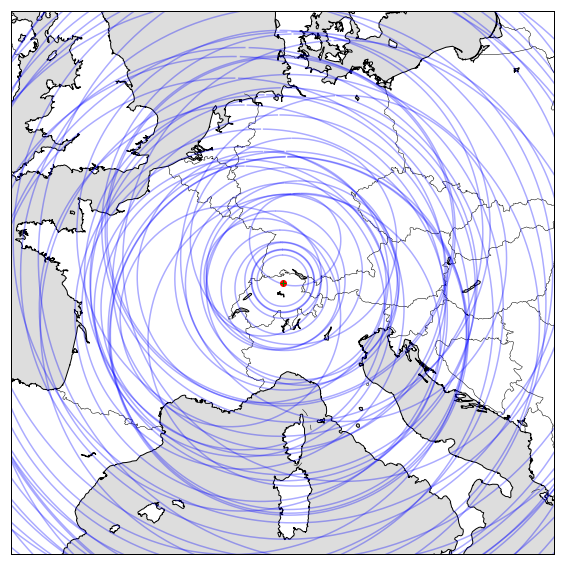

In [9]:
plot_exclusion_circles_by_range(aid_list[2],atlas_min_df,mapscale=2000000)

Exclusion circles for 47 probes around de-muc-as5539


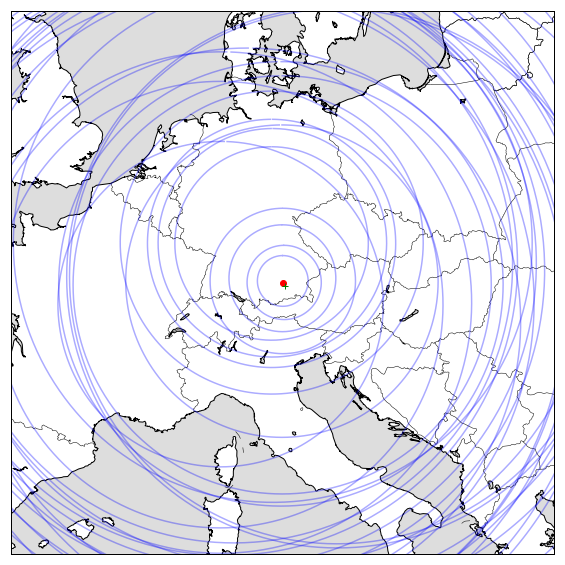

In [10]:
plot_exclusion_circles_by_range(aid_list[3],atlas_min_df,mapscale=2000000)

Exclusion circles for 8 probes around gr-ath-as5408


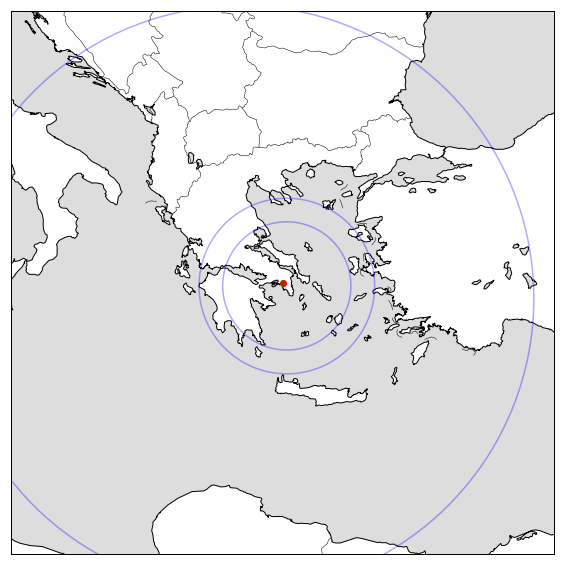

In [11]:
plot_exclusion_circles_by_range(aid_list[4],atlas_min_df, mapscale=1500000)

Exclusion circles for 16 probes around ie-dub-as1213


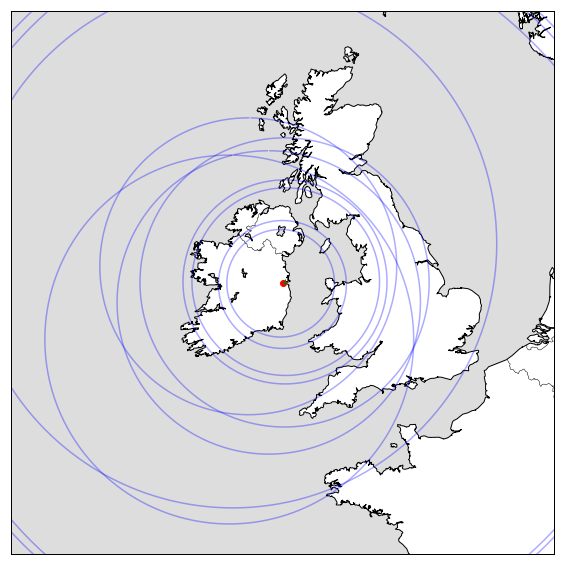

In [12]:
plot_exclusion_circles_by_range(aid_list[5],atlas_min_df, mapscale=1500000)

Exclusion circles for 29 probes around jp-tyo-as2500


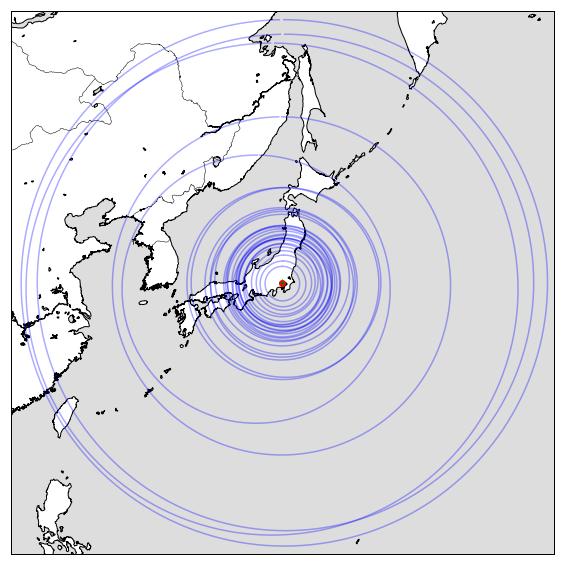

In [13]:
plot_exclusion_circles_by_range(aid_list[6],atlas_min_df)

Exclusion circles for 22 probes around se-sto-as8674


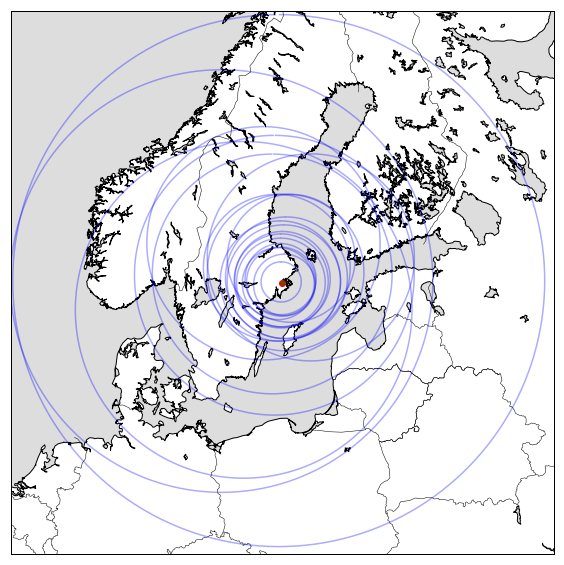

In [14]:
plot_exclusion_circles_by_range(aid_list[7],atlas_min_df, mapscale=2000000)


Exclusion circles for 5 probes around au-mel-as38796


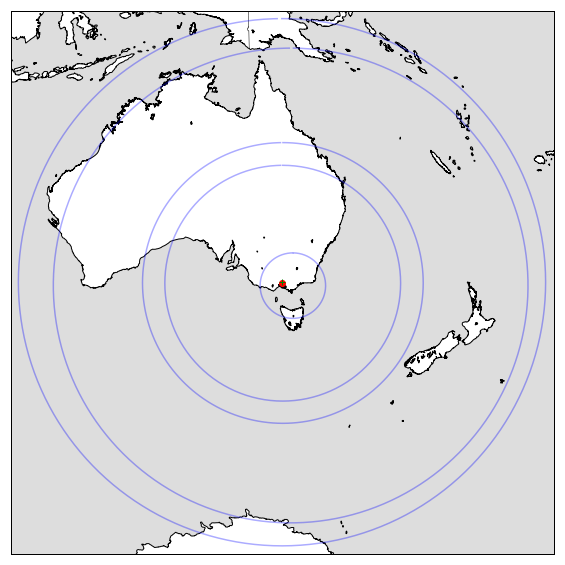

In [15]:
plot_exclusion_circles_by_range(aid_list[8],atlas_min_df)

Exclusion circles for 43 probes around hu-bud-as12303


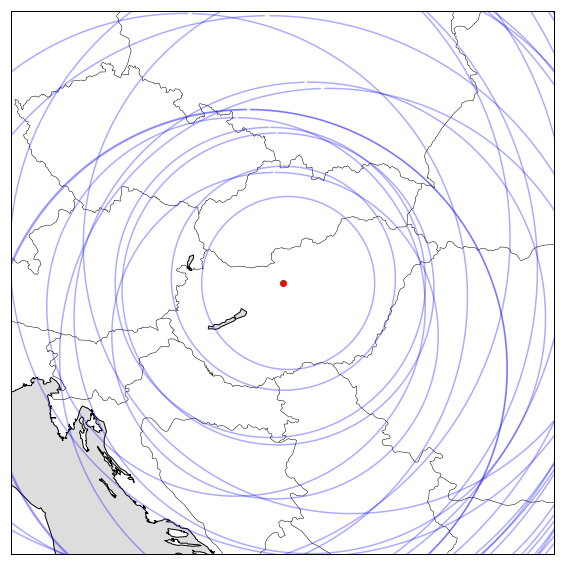

In [16]:
plot_exclusion_circles_by_range(aid_list[9],atlas_min_df, mapscale=1000000)

Exclusion circles for 3 probes around qa-doh-as8781


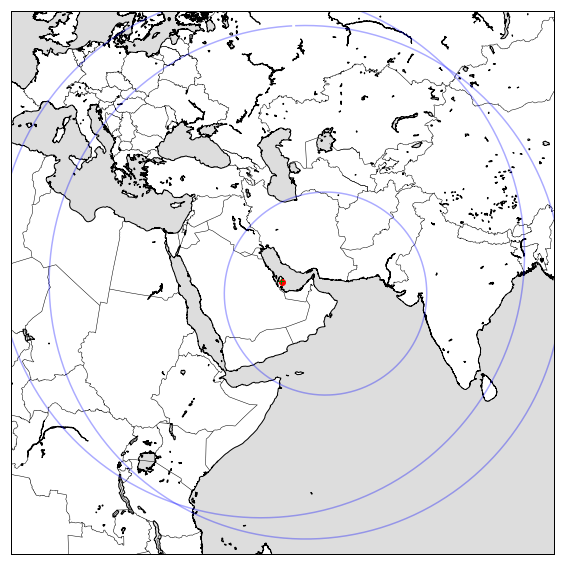

In [17]:
plot_exclusion_circles_by_range(aid_list[10],atlas_min_df)

Exclusion circles for 69 probes around at-vie-as1120


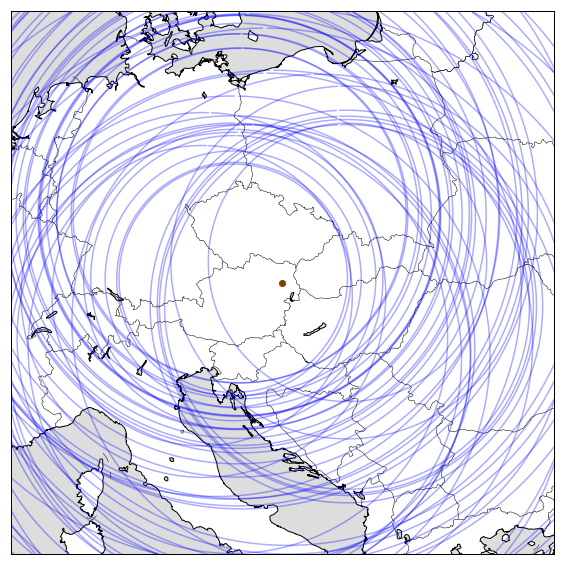

In [49]:
plot_exclusion_circles_by_range(aid_list[11],atlas_min_df,km_range=(100,300),mapscale=1700000)
plt.savefig("../plots/exclusion-at-vie-as1120.pdf")

Exclusion circles for 44 probes around de-fra-as8763


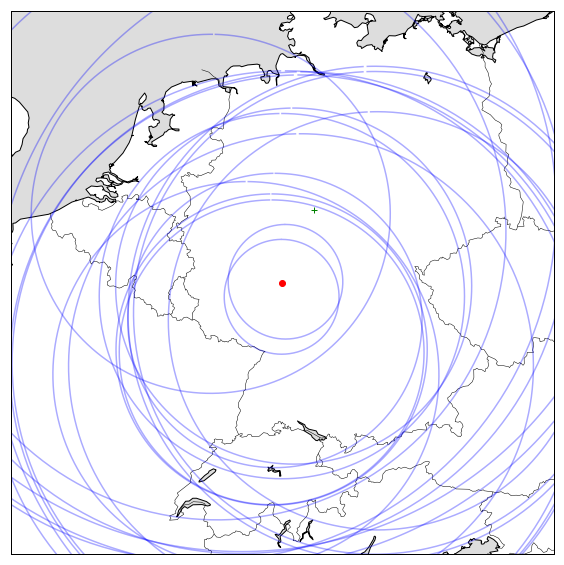

In [19]:
## HERE'S ONE where intersection reduces the circle.

plot_exclusion_circles_by_range(aid_list[12],atlas_min_df,mapscale=1000000)

Exclusion circles for 3 probes around us-den-as7922


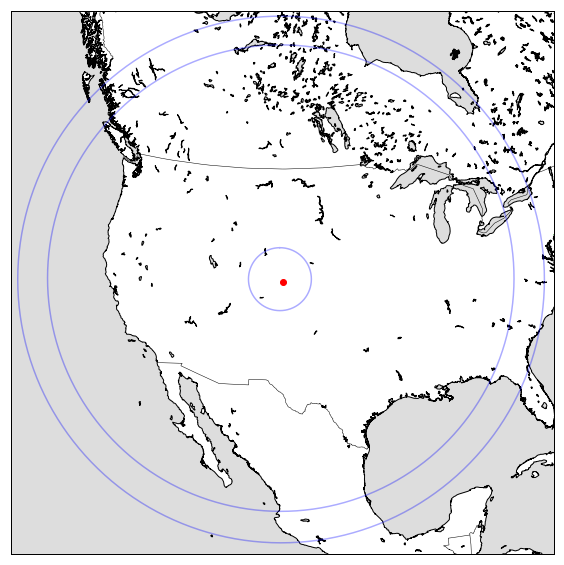

In [20]:
plot_exclusion_circles_by_range(aid_list[13],atlas_min_df)

Exclusion circles for 5 probes around es-bcn-as13041


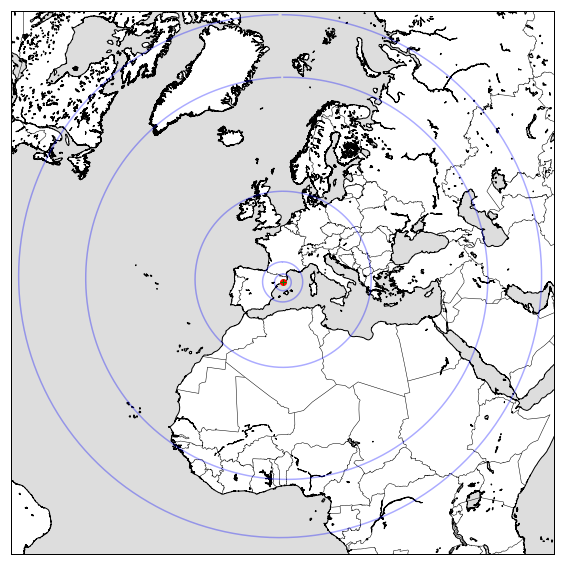

In [21]:
plot_exclusion_circles_by_range(aid_list[14],atlas_min_df)

Exclusion circles for 4 probes around us-dal-as2914


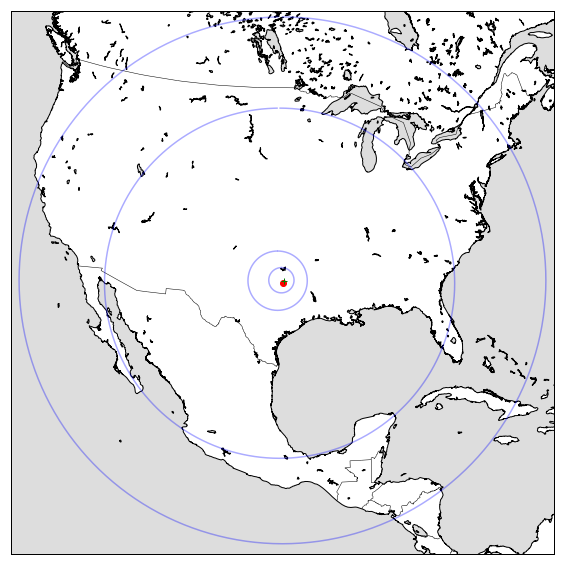

In [22]:
plot_exclusion_circles_by_range(aid_list[15],atlas_min_df)

Exclusion circles for 38 probes around ru-mow-as15835


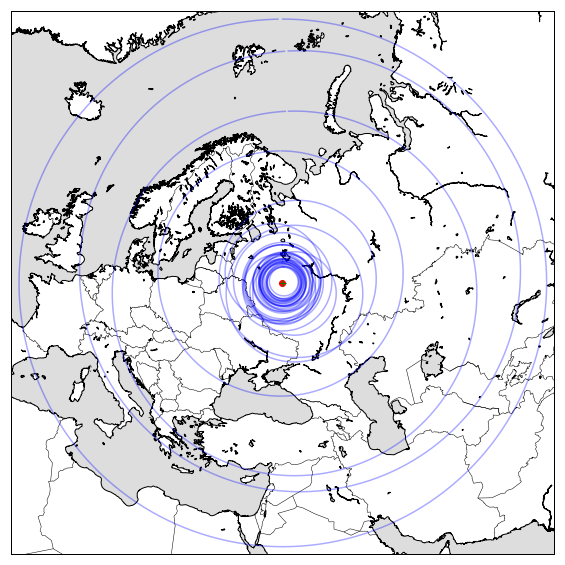

In [23]:
plot_exclusion_circles_by_range(aid_list[16],atlas_min_df)

Exclusion circles for 3 probes around kz-ala-as21299


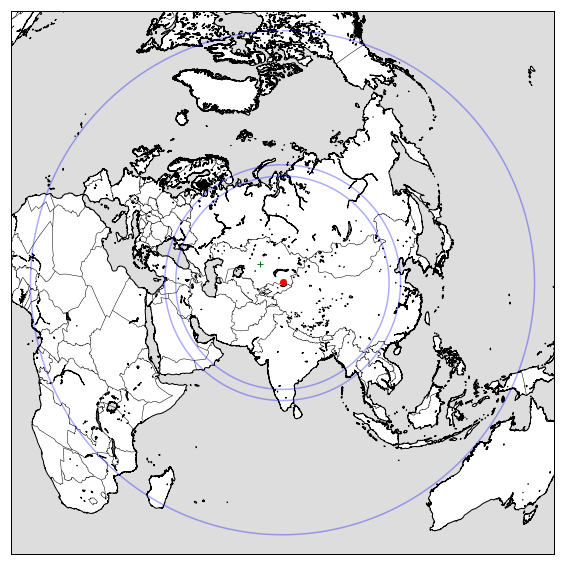

In [24]:
plot_exclusion_circles_by_range(aid_list[17],atlas_min_df,max_rtt=150)

Exclusion circles for 6 probes around hk-hkg-as43996


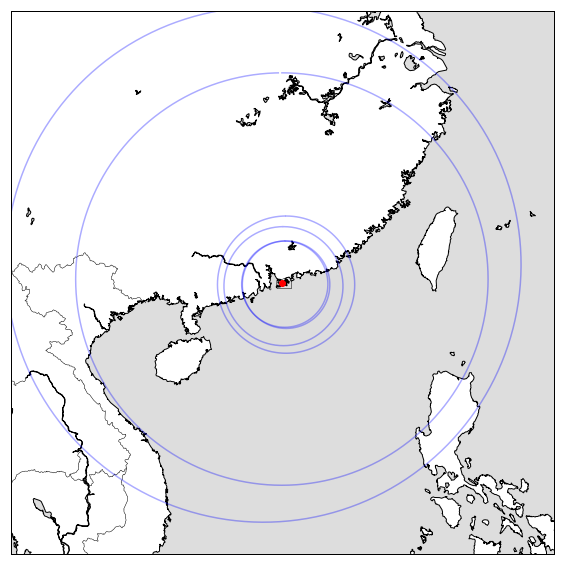

In [25]:
plot_exclusion_circles_by_range(aid_list[18],atlas_min_df)

Exclusion circles for 25 probes around in-bom-as33480


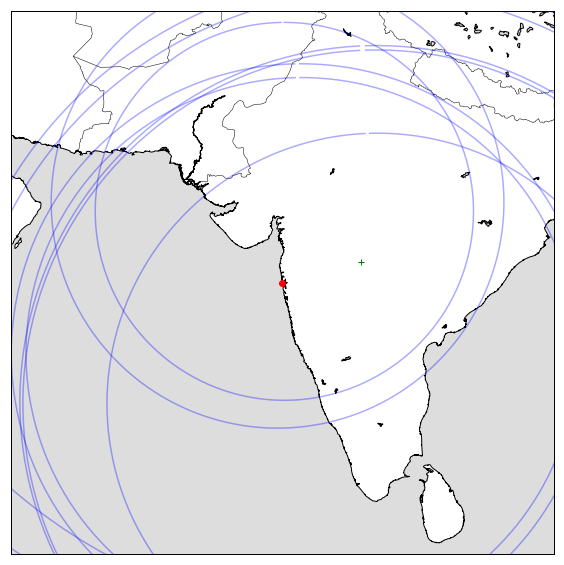

In [26]:
# HERE'S ONE where intersection may reduce the radius of the circle
plot_exclusion_circles_by_range(aid_list[19],atlas_min_df, mapscale=3000000)

Exclusion circles for 112 probes around cz-brq-as197451


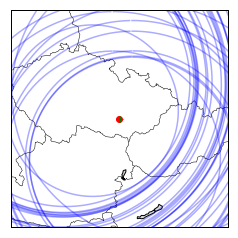

In [52]:
# HERE'S ONE where intersection may reduce the radius of the circle
plot_exclusion_circles_by_range(aid_list[20],atlas_min_df, mapscale=600000, figsize=(4,4))
plt.savefig("../plots/exclusion-cz-brq-as197451.pdf")

Exclusion circles for 7 probes around us-sjc-as22300


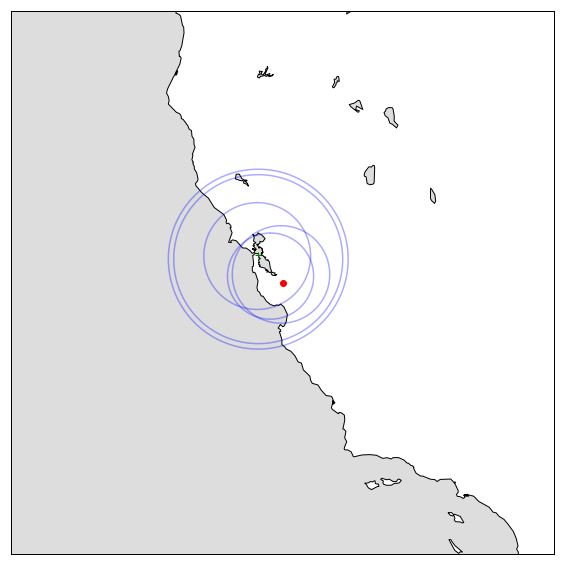

In [28]:
plot_exclusion_circles_by_range(aid_list[21],atlas_min_df, mapscale=1000000)

Exclusion circles for 7 probes around nz-wlg-as9834


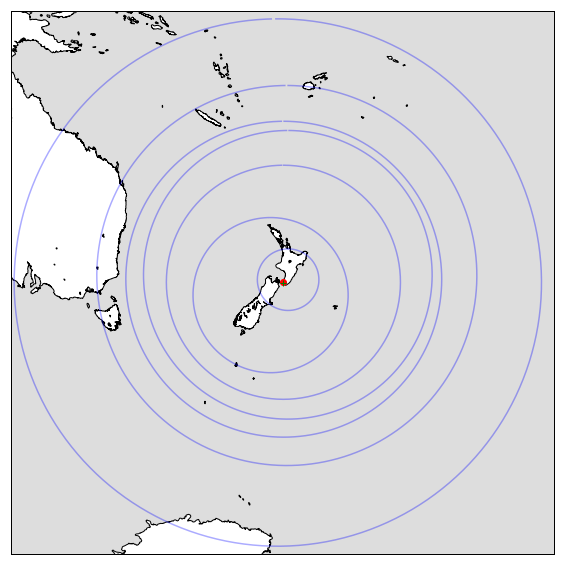

In [29]:
plot_exclusion_circles_by_range(aid_list[22],atlas_min_df)

Exclusion circles for 85 probes around ch-gtg-as20612


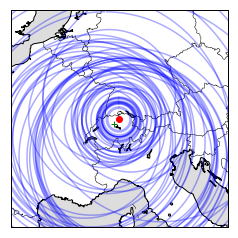

In [30]:
plot_exclusion_circles_by_range(aid_list[23],atlas_min_df, mapscale=1200000,figsize=(4,4))
plt.savefig("../plots/exclusion-ch-gtg-as20612.pdf")

Exclusion circles for 5 probes around bd-dac-as24122


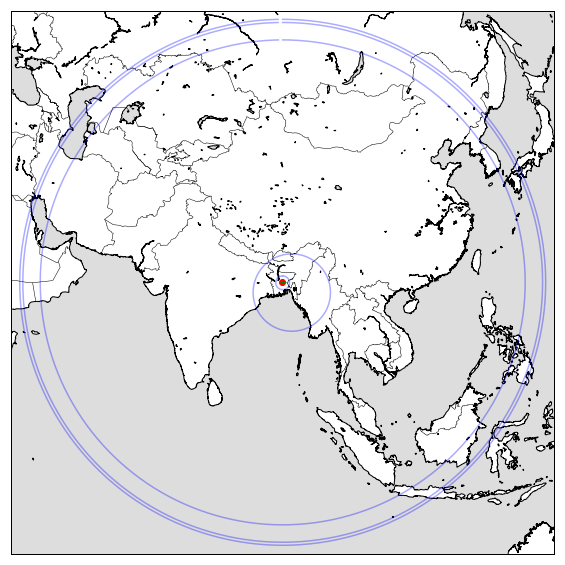

In [31]:
plot_exclusion_circles_by_range(aid_list[24],atlas_min_df)

Exclusion circles for 31 probes around de-ham-as201709


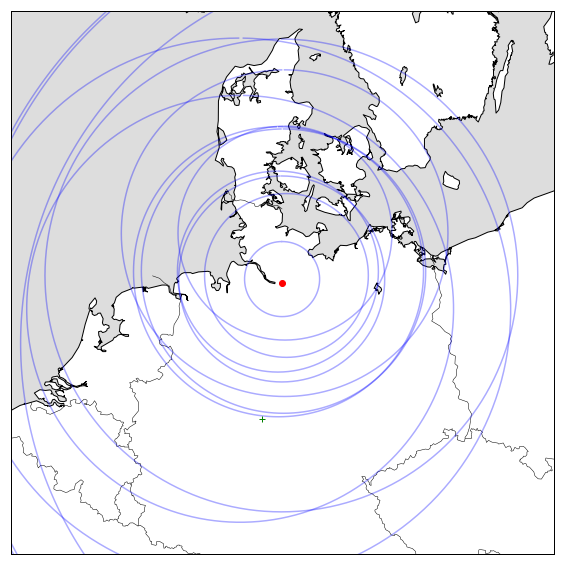

In [32]:
plot_exclusion_circles_by_range(aid_list[25],atlas_min_df, mapscale=1000000)

Exclusion circles for 70 probes around ca-wnp-as18451


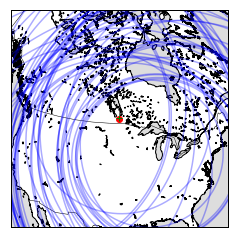

In [58]:
plot_exclusion_circles_by_range(aid_list[26],atlas_min_df, mapscale=4500000, figsize=(4,4))
plt.savefig("../plots/exclusion-ca-wnp-as18451.pdf")

Exclusion circles for 14 probes around id-jkt-as10208


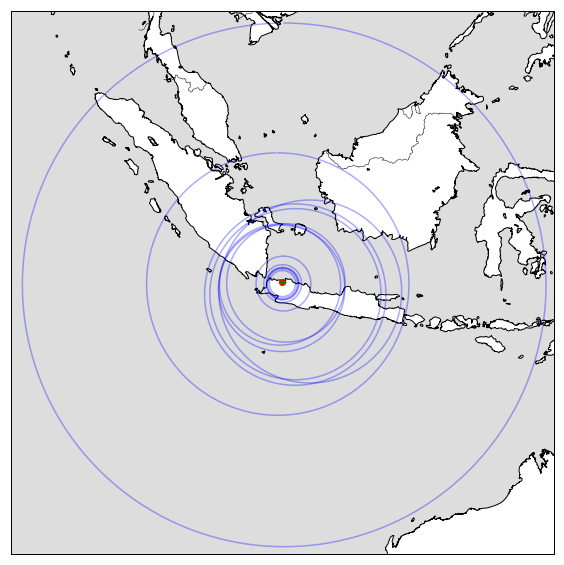

In [34]:
plot_exclusion_circles_by_range(aid_list[27],atlas_min_df)

Exclusion circles for 41 probes around nl-haa-as201682


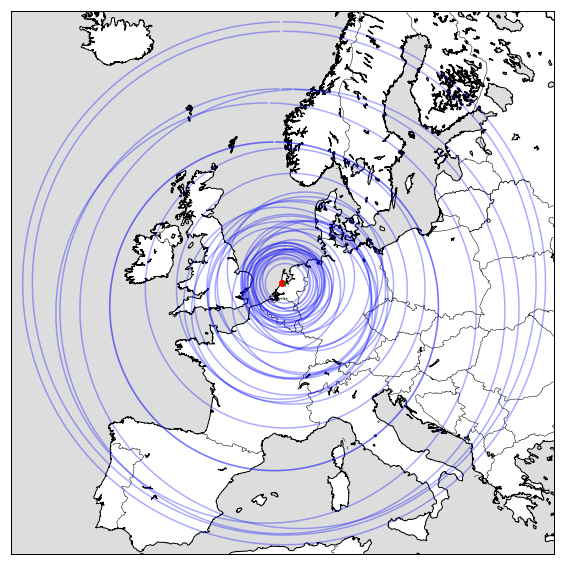

In [35]:
plot_exclusion_circles_by_range(aid_list[28],atlas_min_df)

Exclusion circles for 45 probes around us-mia-as33280


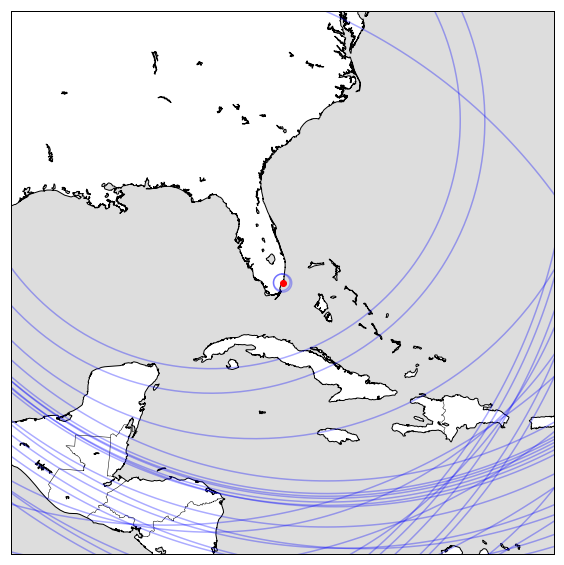

In [36]:
plot_exclusion_circles_by_range(aid_list[29],atlas_min_df, mapscale=3000000)

Exclusion circles for 5 probes around ca-mtr-as852


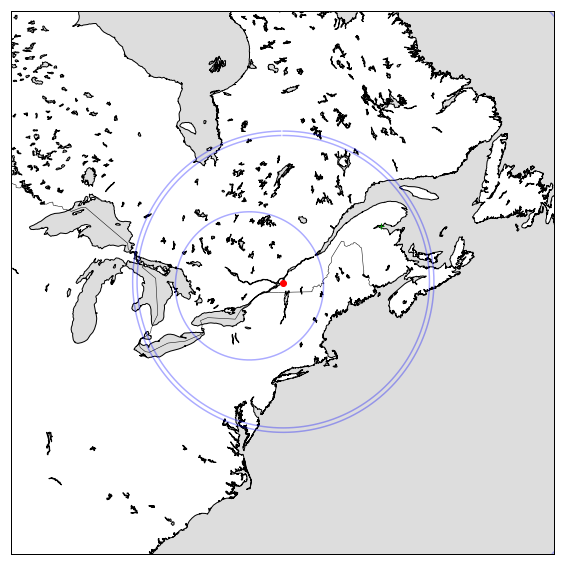

In [37]:
plot_exclusion_circles_by_range(aid_list[30],atlas_min_df, mapscale=3000000)

Exclusion circles for 7 probes around ar-bue-as4270


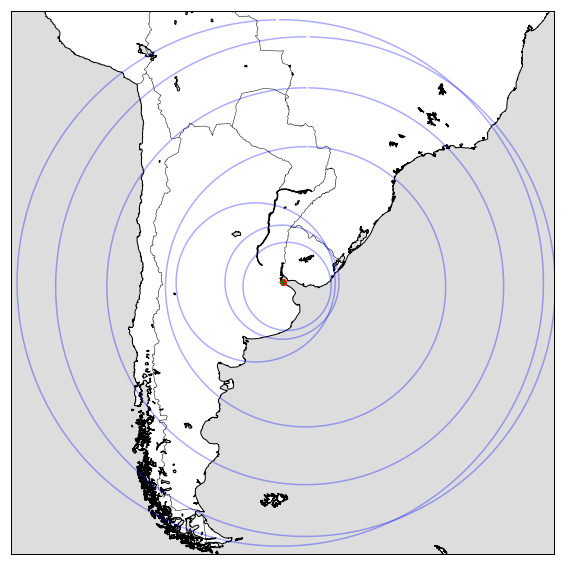

In [38]:
plot_exclusion_circles_by_range(aid_list[31],atlas_min_df)

Exclusion circles for 22 probes around uk-lon-as5607


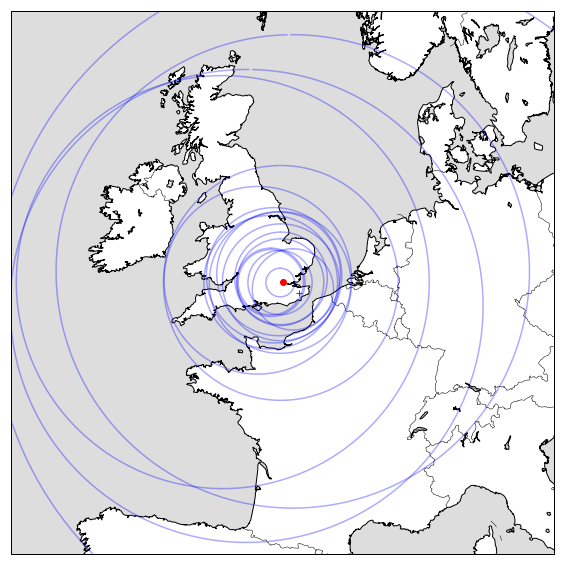

In [39]:
plot_exclusion_circles_by_range(aid_list[32],atlas_min_df, mapscale=2000000)

Exclusion circles for 9 probes around ee-tll-as51349


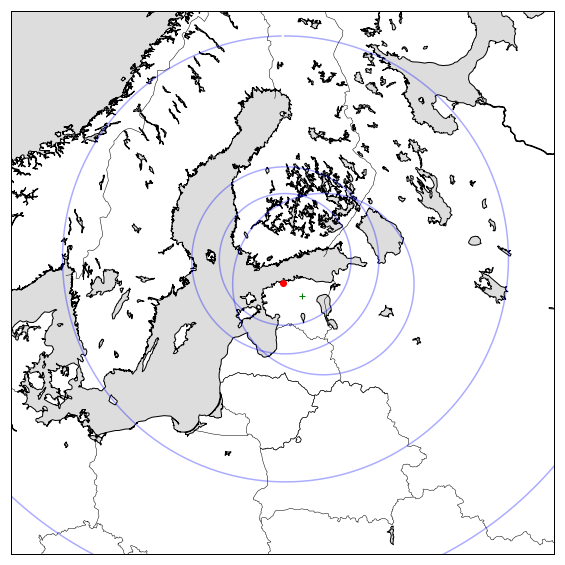

In [40]:
#HERE'S ONE 

plot_exclusion_circles_by_range(aid_list[33],atlas_min_df, mapscale=2000000)

Exclusion circles for 10 probes around ke-nbo-as37578


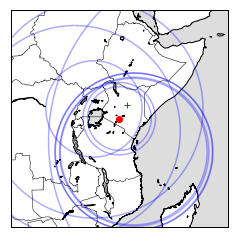

In [41]:
# HERE'S ONE

plot_exclusion_circles_by_range(aid_list[34],atlas_min_df, mapscale=4000000, figsize=(4,4))
plt.savefig("../plots/exclusion-ke-nbo-as37578.pdf")

Exclusion circles for 6 probes around bg-sof-as8866


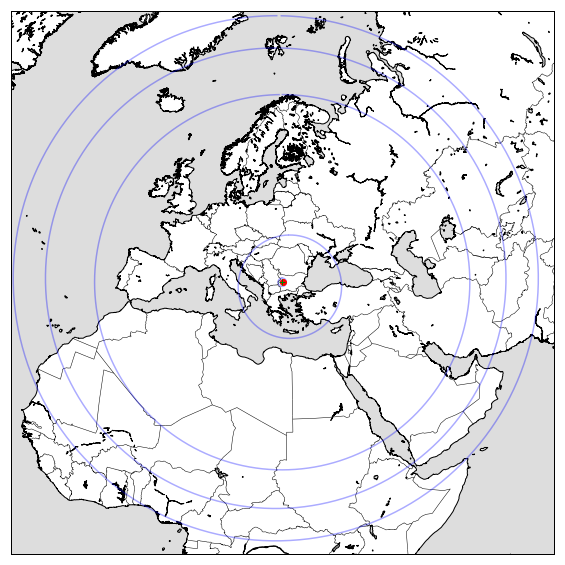

In [42]:
plot_exclusion_circles_by_range(aid_list[35],atlas_min_df)

Exclusion circles for 20 probes around fr-par-as1307


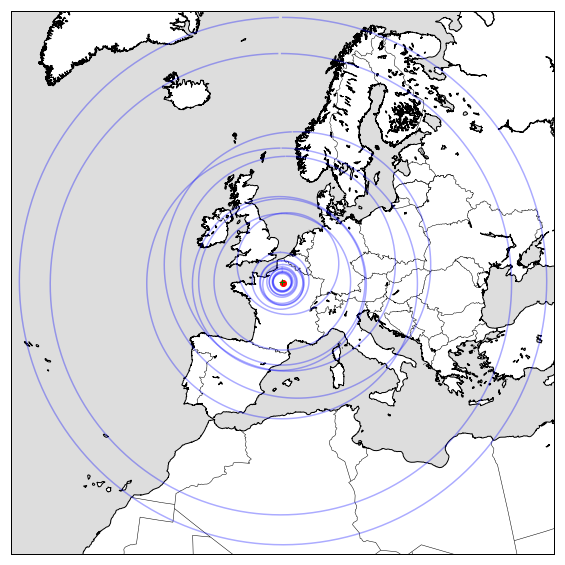

In [43]:
plot_exclusion_circles_by_range(aid_list[36],atlas_min_df)

Exclusion circles for 7 probes around au-bne-as4608-2


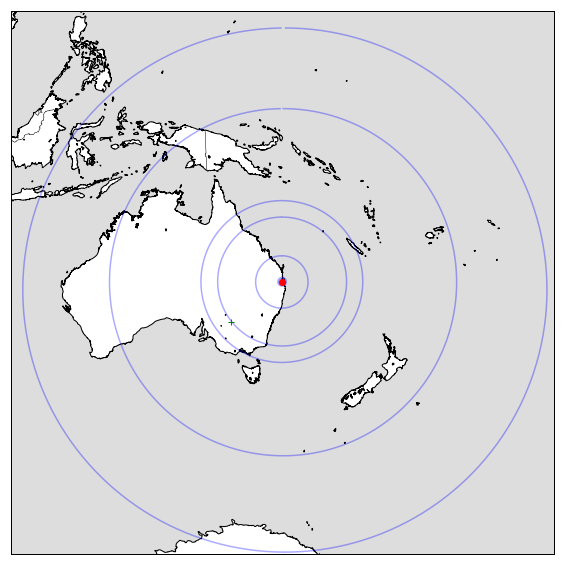

In [44]:
plot_exclusion_circles_by_range(aid_list[37],atlas_min_df)

Exclusion circles for 632 probes around bf-oua-as37577


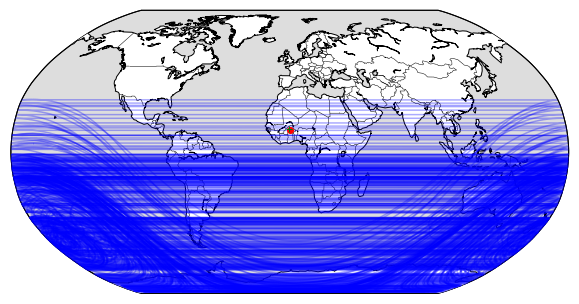

In [45]:
plot_exclusion_circles_by_range(aid_list[38],atlas_min_df,max_rtt=100)

### Compare nearest-probe assumption to IPv4 geolocation accuracy

In [88]:
EARTH_RADIUS = 6371 # radius of Earth in kilometers

def calc_error_distance(df, lon0col = 'alon', lat0col = 'alat', lon1col = 'mm4lon', lat1col='mm4lat', errcol='mmerrkm'):
    
    lon0 = df[lon0col]
    lat0 = df[lat0col]
    lon1 = df[lon1col]
    lat1 = df[lat1col]
    
    df['tmp_aphi'] = (90.0 - lat0) * math.pi/180.0
    df['tmp_pphi'] = (90.0 - lat1) * math.pi/180.0
    df['tmp_atheta'] = lon0 * math.pi/180.0
    df['tmp_ptheta'] = lon1 * math.pi/180.0
    df['tmp_cos'] = ( np.sin(df['tmp_aphi']) * np.sin(df['tmp_pphi']) * 
                          np.cos(df['tmp_atheta'] - df['tmp_ptheta']) + 
                          np.cos(df['tmp_aphi']) * np.cos(df['tmp_pphi']) )
    df[errcol] = np.arccos(df['tmp_cos']) * EARTH_RADIUS
    del df['tmp_aphi']
    del df['tmp_pphi']
    del df['tmp_atheta']
    del df['tmp_ptheta']
    del df['tmp_cos']

In [89]:
calc_error_distance(atlas_min_df)

In [90]:
atlas_min_df[atlas_min_df['fiber_km'] < atlas_min_df['mmerrkm']]

plon     plat        alon       alat  minhops  minrtt    n  \
aid  pid                                                                     
4    3500     7.6775  45.0575    7.660600  45.091300        4   1.471  288   
     6094     9.1015  45.4795    7.660600  45.091300        4   3.606  288   
     18213    7.6575  45.1085    7.660600  45.091300        5   0.798  288   
342  4063     8.6305  50.0985    8.663789  50.107145        4   1.236  288   
     6105     8.7275  50.1195    8.663789  50.107145       10   0.765  576   
     6141     8.6795  50.1075    8.663789  50.107145        3   0.322  576   
     6152     8.6795  50.1085    8.663789  50.107145        5   0.773  574   
     6186     8.6415  49.8705    8.663789  50.107145        6   1.034  576   
     6293     8.6315  50.0985    8.663789  50.107145        5   0.667  576   
     6294     8.7415  50.1195    8.663789  50.107145        5   1.032  576   
     11616    8.6775  50.1205    8.663789  50.107145        9   1.110  279   
343  6061   -96.8195  32.7975 -104.984718  39.737567        8  14.761  574   
     6067   -96.8595  32.8105 -104.984718  39.737567        8  15.017  576   
     6080  -104.9785  39.7375 -104.984718  39.737567        1   0.109  576   
     6093   -96.9285  32.9885 -104.984718  39.737567       10  20.504  576   
     6101  -112.0125  33.4175 -104.984718  39.737567       12  23.814  288   
     6208  -113.6225  37.0815 -104.984718  39.737567        9  17.593  576   
     6257   -94.7505  38.9305 -104.984718  39.737567        8  24.775  576   
     6259   -87.6305  41.8815 -104.984718  39.737567        8  23.688  576   
     6265   -96.7995  32.7795 -104.984718  39.737567        9  14.805  576   
     6280   -87.9685  41.9975 -104.984718  39.737567        8  24.297  576   
     10334 -105.1715  40.0995 -104.984718  39.737567        9  20.800  288   
     15844 -106.3905  31.7095 -104.984718  39.737567       10  14.860  288   
     16470 -105.1395  39.9875 -104.984718  39.737567       10  23.515  288   
     17218 -112.0225  40.4915 -104.984718  39.737567        9  18.964  288   
     17914  -97.3025  32.9495 -104.984718  39.737567       12  17.072  287   
     18664 -105.2595  40.0095 -104.984718  39.737567       13   2.793  288   
396  813     76.9475  43.2585   76.895833  43.277500        7   2.235  287   
423  2283   139.7315  35.6985  114.109497  22.396428       15  79.227  288   
     4430   103.6885   1.3175  114.109497  22.396428        8  35.214  288   
...              ...      ...         ...        ...      ...     ...  ...   
     27131  137.9485  36.1075  114.109497  22.396428       16  55.133  288   
     27284  139.6915  35.7395  114.109497  22.396428       16  52.827  285   
     29822  106.8185  -6.1715  114.109497  22.396428       12  50.215  288   
     30230  106.8585  -6.1725  114.109497  22.396428       13  46.656  288   
     30642  114.2095  22.3285  114.109497  22.396428        8   1.913  288   
547  6122  -121.8915  37.3285 -121.891486  37.334198        1   0.102  576   
561  6115     8.5575  47.4395    8.559989  47.435176        1   0.089  576   
     22910    8.5575  47.4275    8.559989  47.435176        5   0.422  576   
598  4615    10.0175  53.6095   10.038970  53.550980        9   1.855  576   
     6052    10.1095  54.3685   10.038970  53.550980       11   1.927  576   
     6210    10.0275  53.6075   10.038970  53.550980        7   0.676  576   
     15869    9.9105  53.7315   10.038970  53.550980        9   1.810  576   
     29651   10.1495  53.6675   10.038970  53.550980       11   1.475  285   
639  6062   -80.2295  25.7885  -80.193053  25.782360        6   0.449  576   
     6066   -84.4195  33.7705  -80.193053  25.782360        7  13.415  576   
     6236   -81.8715  35.3305  -80.193053  25.782360       14  18.850  576   
     6266   -80.1895  25.7605  -80.193053  25.782360        6   0.494  576   
     6285   -84.3885  33.7495  -80.193053  25.782360        8  14.718  576   
644  11153  -75.9005  45.3085  -73.565

In [91]:
atlas_min_df[atlas_min_df['fiber_km'] < atlas_min_df['mmerrkm']].groupby('aid')['n'].count()

aid
4        3
342      8
343     16
396      1
423     87
547      1
561      2
598      5
639      5
644      1
687      4
742      1
998      5
1038     1
Name: n, dtype: int64

In [ ]:
len(atlas_min_df)

In [69]:
159/22120

0.007188065099457504

In [81]:
anchor_df.loc[423]

name            hk-hkg-as43996
pid                       6145
ip4              185.28.220.65
ip6       2a01:5040:1000:30::1
asn4                     43996
asn6                     43996
cc                          HK
lon                    114.109
lat                    22.3964
mm4lon                  4.8995
mm4lat                 52.3824
Name: 423, dtype: object

In [6]:
def ecdf(ser):
    ser = ser.sort_values()
    cdf = np.linspace(0.,1.,len(ser))
    return pd.Series(cdf, index=ser)

EARTH_RADIUS = 6371 # radius of Earth in kilometers

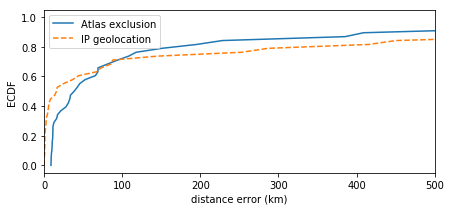

In [78]:
plt.figure(figsize=(7,3))
min_no_self_df = atlas_min_df[atlas_min_df['km'] > 0.5]
plt.plot(ecdf(min_no_self_df.groupby("aid")['fiber_km'].min()), 
         label="Atlas exclusion")
plt.plot(ecdf(min_no_self_df.groupby("aid")['mmerrkm'].min()), 
         label="IP geolocation", linestyle="--")

plt.xlim(0,500)
plt.ylabel("ECDF")
plt.xlabel("distance error (km)")
plt.legend()
plt.savefig("../plots/atlaslocerr.pdf")

In [74]:
min_no_self_df.groupby("aid")['mmerrkm'].min().quantile(0.5)

15.917338019867874